# Homework 3: VQ-VAE and WGAN

```
your solution
```

In [ ]:
COMMIT_HASH = "79dfd7865ba692235f0a4d5aed20ee2820a19007"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

In [1]:
from dgm_utils import train_model, train_adversarial
from dgm_utils import show_samples, visualize_images, load_dataset
from dgm_utils import BaseModel

In [2]:
import os
import numpy as np

from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

if torch.cuda.is_available():
    DEVICE = "cuda"
    print('GPU found :)')
else:
    DEVICE = "cpu"
    print('GPU not found :(')

GPU found :)


## Task 3: Wasserstein GANs for CIFAR 10 (4pt)

In this task you will fit different kinds of Wasserstein GANs (different ways to enforce Lipschitzness) that we discussed at the lecture to the CIFAR10 dataset
* [WGAN](https://arxiv.org/abs/1701.07875) - standard Wasserstein GAN with weight clipping;
* [WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf) - Wasserstein GAN with Gradient Penalty.

100%|██████████| 170M/170M [00:19<00:00, 8.55MB/s] 


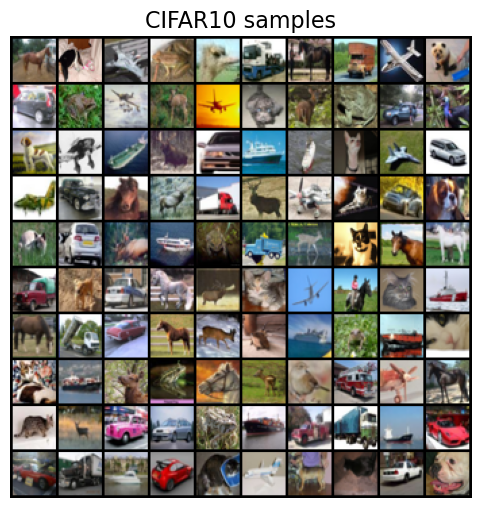

In [3]:
train_data, test_data = load_dataset("cifar10", flatten=False, binarize=False)
visualize_images(train_data, "CIFAR10 samples")

### Problem 1: WGAN (3pt)

[WGAN](https://arxiv.org/abs/1701.07875) model uses weight clipping to enforce Lipschitzness of the critic.

The model objective is
$$
\min_{G} W(\pi || p) \approx \min_{G} \max_{\boldsymbol{\phi} \in \boldsymbol{\Phi}} \left[ \mathbb{E}_{\pi(\mathbf{x})} f_{\boldsymbol{\phi}}(\mathbf{x})  - \mathbb{E}_{p(\mathbf{z})} f_{\boldsymbol{\phi}}(G_{\boldsymbol{\theta}}(\mathbf{z}))\right].
$$
Here $f_{\boldsymbol{\phi}}(\mathbf{x})$ is the critic model. The critic weights $\boldsymbol{\phi}$ should lie in the compact set $\boldsymbol{\Phi} = [-c, c]^d$.

In this task we will use convolutional networks for the generator $G_{\boldsymbol{\theta}}(\mathbf{z})$ and the critic $f_{\boldsymbol{\phi}}(\mathbf{x})$.

First of all, let define generator network. It will be the same for all WGAN models.

In [4]:
class GeneratorBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, upsample: bool = False) -> None:
        super().__init__()

        self.upsample = upsample
        if in_channels != out_channels:
            self.shortcut_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut_conv = None

        # ====
        # your code
        # define the layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # ====
        # your code
        # 1) create shortcut: if upsample is True, apply upsampling
        # 2) if shortcut_conv is not None, apply it
        # 3) apply main conv layers to x
        # NOTE: do not forget to add shortcut to x at the end
        shortcut = x
        if self.upsample:
            shortcut = F.interpolate(shortcut, scale_factor=2, mode='nearest')
        if self.shortcut_conv is not None:
            shortcut = self.shortcut_conv(shortcut)
        
        out = F.relu(self.bn1(self.conv1(x)))
        if self.upsample:
            out = F.interpolate(out, scale_factor=2, mode='nearest')
        out = self.bn2(self.conv2(out))
        
        return F.relu(out + shortcut)
        # ====

In [5]:
class ConvGenerator(nn.Module):
    def __init__(self, input_size: int = 128, n_channels: int = 64) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.input_size = input_size
        # ====
        # your code
        # define the model as a sequence of layers
        # 1) start with Linear layer
        # 2) then define generator blocks
        # 3) create last conv layer with tanh activation
        layers = []
        # Linear layer: input_size -> 4*4*n_channels
        layers.append(nn.Linear(input_size, 4 * 4 * n_channels))
        layers.append(nn.ReLU())
        
        # Generator blocks with upsampling
        # 4x4 -> 8x8
        layers.append(GeneratorBlock(n_channels, n_channels, upsample=True))
        # 8x8 -> 16x16
        layers.append(GeneratorBlock(n_channels, n_channels, upsample=True))
        # 16x16 -> 32x32
        layers.append(GeneratorBlock(n_channels, n_channels, upsample=True))
        
        # Final conv layer: n_channels -> 3 (RGB) with tanh
        layers.append(nn.Conv2d(n_channels, 3, kernel_size=3, padding=1))
        layers.append(nn.Tanh())
        
        self.net = nn.Sequential(*layers)
        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # apply all layers
        out = self.net[0](x)  # Linear
        out = F.relu(out)
        out = out.view(-1, self.n_channels, 4, 4)
        
        # Apply generator blocks (indices 1, 2, 3)
        for i in range(1, 4):
            out = self.net[i](out)
        
        # Apply final conv + tanh (indices 4, 5)
        out = self.net[4](out)
        out = self.net[5](out)
        
        return out
        # ====
        
        
def test_conv_generator():
    model = ConvGenerator(input_size=4, n_channels=32)
    x = torch.randn((2, 4))
    out = model(x)
    assert list(out.size()) == [2, 3, 32, 32], out.size()
    
test_conv_generator()

Now it is time to define our critic. Here we will use the same class for all WGAN models, but the arguments will depend on the WGAN mode.

In [6]:
def avg_pool2d(x: torch.Tensor) -> torch.Tensor:
    return (x[:, :, ::2, ::2] + x[:, :, 1::2, ::2] + x[:, :, ::2, 1::2] + x[:, :, 1::2, 1::2]) / 4

class CriticBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, downsample=False, first=False):
        super().__init__()

        self.downsample = downsample
        self.first = first

        if in_channels != out_channels:
            self.shortcut_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut_conv = None
        # ====
        # your code
        # define the layers if block is first do not define ReLU
        # NOTE: do not use BatchNorm, because the gradient penalty (next task) 
        # should be independently imposed on different samples, 
        # but batch normalization brings batch correlation.
        if self.first:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        # ====

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) create shortcut: if downsample is True, apply avg_pool
        # 2) if shortcut_conv is not None, apply it
        # 3) apply main conv layers to x
        # NOTE: do not forget to add shortcut to x at the end
        shortcut = x
        if self.downsample:
            shortcut = avg_pool2d(shortcut)
        if self.shortcut_conv is not None:
            shortcut = self.shortcut_conv(shortcut)
        
        if self.first:
            out = self.conv1(x)
        else:
            out = self.relu1(self.conv1(x))
        
        if self.downsample:
            out = avg_pool2d(out)
        
        out = self.relu2(self.conv2(out))
        
        return out + shortcut
        # ====

In [7]:
class ConvCritic(nn.Module):
    def __init__(
        self, n_channels: int, clip_c: Optional[float] = None,
    ) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.clip_c = clip_c
        
        # ====
        # your code
        # define the model as a sequence of layers
        # 1) define generator blocks
        # 2) do not use sigmoid activation at the end!
        layers = []
        # First block: 3 (RGB) -> n_channels, downsample
        layers.append(CriticBlock(3, n_channels, downsample=True, first=True))
        # n_channels -> n_channels*2, downsample
        layers.append(CriticBlock(n_channels, n_channels * 2, downsample=True, first=False))
        # n_channels*2 -> n_channels*4, downsample
        layers.append(CriticBlock(n_channels * 2, n_channels * 4, downsample=True, first=False))
        # n_channels*4 -> n_channels*8, downsample
        layers.append(CriticBlock(n_channels * 4, n_channels * 8, downsample=True, first=False))
        
        # Final layers: flatten and linear
        # After 4 downsample operations: 32x32 -> 16x16 -> 8x8 -> 4x4 -> 2x2
        layers.append(nn.Flatten())
        layers.append(nn.Linear(n_channels * 8 * 2 * 2, 1))
        
        self.net = nn.Sequential(*layers)
        # ====

    def clip_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                # ====
                # your code
                # clip the weight to the range [-clip_c, clip_c]
                weight = torch.clamp(module.weight.data, -self.clip_c, self.clip_c)
                if module.bias is not None:
                    bias = torch.clamp(module.bias.data, -self.clip_c, self.clip_c)
                else:
                    bias = None
                # ====
                module.weight.data = weight
                if bias is not None:
                    module.bias.data = bias

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) clip the critic weights (if clip_c is given)
        # 2) apply all layers
        if self.clip_c is not None:
            self.clip_weights()
        
        output = self.net(x)
        # ====
        return output
        
        
def test_conv_critic():
    model = ConvCritic(n_channels=4, clip_c=0.01)
    x = torch.randn((2, 3, 32, 32))
    out = model(x)
    assert list(out.size()) == [2, 1], out.size()

    
test_conv_critic()

In [35]:
class WGAN(BaseModel):
    def __init__(
        self,
        input_size: int = 128, 
        n_channels: int = 64, 
        clip_c: Optional[float] = None,
    ) -> None:
        super().__init__()
        self.input_size = input_size
        self.generator = ConvGenerator(input_size, n_channels)
        self.discriminator = ConvCritic(n_channels, clip_c)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.generator(x)
    
    def loss_generator(self, batch_size) -> dict:
        # ====
        # your code
        # 1) sample batch 
        # NOTE: sample function uses torch.no_grad
        # 2) apply generator loss (only term with genrator)
        z = torch.randn(batch_size, self.input_size).to(next(self.generator.parameters()).device)
        fake_data = self.generator(z)
        d_fake = self.discriminator(fake_data)
        # Generator wants to maximize D(fake), so we minimize -D(fake)
        g_loss = -d_fake.mean()
        # ====
        return {"generator_loss": g_loss}

    def loss_discriminator(self, x: torch.Tensor) -> dict:
        # Generate fake data directly (not using sample() which has no_grad)
        z = torch.randn(x.shape[0], self.input_size).to(next(self.generator.parameters()).device)
        fake_data = self.generator(z)
        # ====
        # your code
        # calculate critic loss (both terms)
        d_real = self.discriminator(x)
        d_fake = self.discriminator(fake_data)
        
        # Critic wants to maximize D(real) - D(fake), so we minimize -(D(real) - D(fake))
        d_loss_real = -d_real.mean()
        d_loss_fake = d_fake.mean()
        d_loss = d_loss_real + d_loss_fake
        # ====
        return {"critic_loss": d_loss, "critic_loss_fake": d_loss_fake, "critic_loss_real": d_loss_real}
    
    @torch.no_grad()
    def sample(self, n_samples: int) -> torch.Tensor:
        # ====
        # your code
        # sample from standard normal distribution and apply the model
        z = torch.randn(n_samples, self.input_size).to(next(self.generator.parameters()).device)
        output = self.generator(z)
        # ====
        return output
    
def test_wgan():
    model = WGAN(input_size=4, n_channels=32)
    x = torch.randn((2, 4))
    out = model(x)
    assert list(out.size()) == [2, 3, 32, 32], out.size()
    
    out = model.sample(10)
    assert list(out.size()) == [10, 3, 32, 32], out.size()

    loss = model.loss_generator(10)
    assert isinstance(loss, dict)
    
    x = torch.randn((2, 3, 32, 32))
    loss = model.loss_discriminator(x)
    assert isinstance(loss, dict)
    
test_wgan()
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


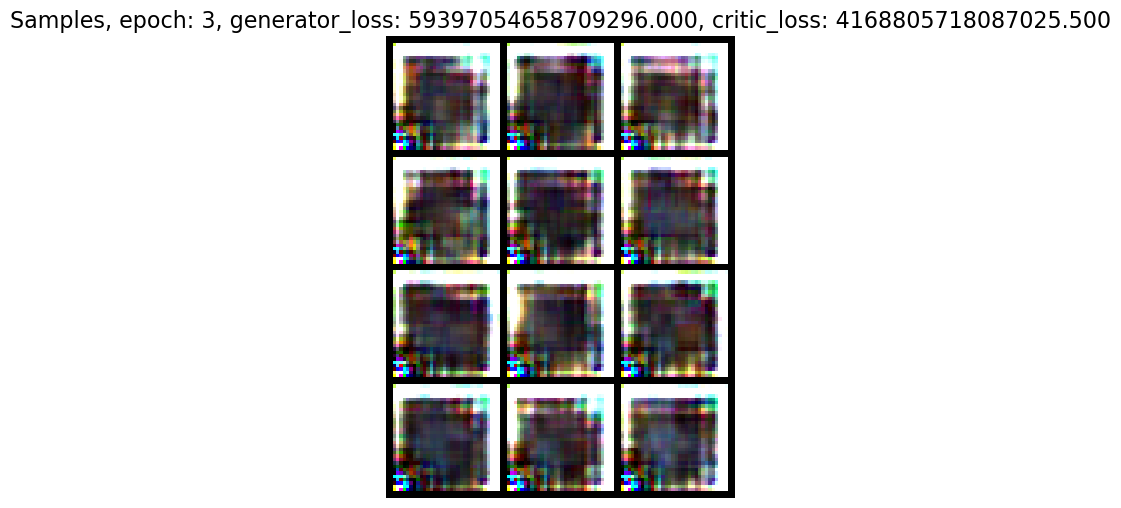

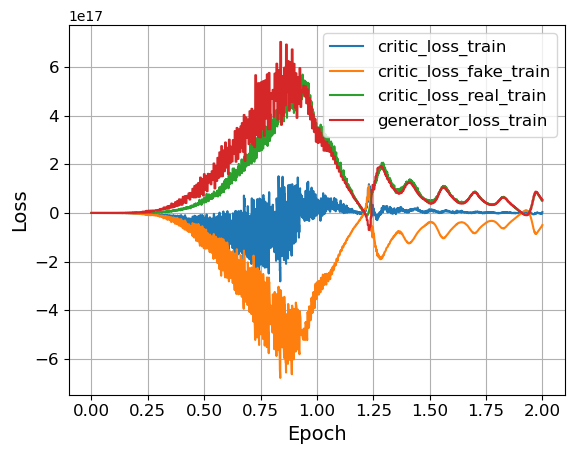

Training epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 64
N_CHANNELS = 64
EPOCHS = 100
CRITIC_STEPS = 5
CLIP_C = 0.001
LR = 2e-4
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
wgan = WGAN(input_size=128, n_channels=N_CHANNELS, clip_c=CLIP_C)

# choose any optimizer as you want
generator_optimizer = torch.optim.RMSprop(wgan.generator.parameters(), lr=LR)
discriminator_optimizer = torch.optim.RMSprop(wgan.discriminator.parameters(), lr=LR)

train_adversarial(
    wgan,
    train_loader,
    epochs=EPOCHS,
    d_steps=CRITIC_STEPS,
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    device=DEVICE,
    generator_loss_key="generator_loss",
    discriminator_loss_key="critic_loss",
    n_samples=12,
    visualize_samples=True
)

Let sample from our model and draw the samples.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


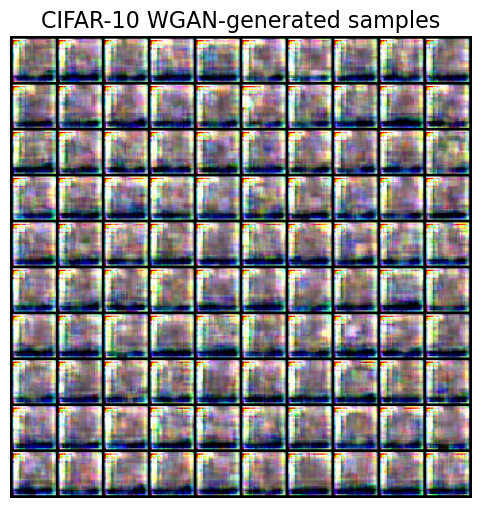

In [41]:
wgan.eval()
samples = wgan.sample(100).cpu().detach().numpy()

show_samples(samples, title="CIFAR-10 WGAN-generated samples")

### Problem 2: WGAN-GP for CIFAR 10 (2pt)

Another way to enforce Lipschitzness comes from the following [theorem](https://arxiv.org/pdf/1704.00028.pdf):

Let $\pi(\mathbf{x})$ and $p(\mathbf{x})$ be two distribution in $\mathcal{X}$, a compact metric space. Let $\gamma$ be the optimal transportation plan between $\pi(\mathbf{x})$ and $p(\mathbf{x})$. Then, there is 1-Lipschitz function $f^*$ which is the optimal solution of 
$$
    \max_{\| f \|_L \leq 1} \left[ \mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x})} f(\mathbf{x})\right].
$$

if $f^*$ is differentiable, $\gamma(\mathbf{y} = \mathbf{z}) = 0$ and $\hat{\mathbf{x}}_t = t \mathbf{y} + (1 - t) \mathbf{z}$ with $\mathbf{y} \sim \pi(\mathbf{x})$, $\mathbf{z} \sim p(\mathbf{x} | \mathbf{\theta})$, $t \in [0, 1]$ it holds that
$$
    \mathbb{P}_{(\mathbf{y}, \mathbf{z}) \sim \gamma} \left[ \nabla f^*(\hat{\mathbf{x}}_t) = \frac{\mathbf{z} - \hat{\mathbf{x}}_t}{\| \mathbf{z} - \hat{\mathbf{x}}_t \|} \right] = 1.
$$

This follows that $f^*$ has gradient norm 1 almost everywhere under $\pi(\mathbf{x})$ and $p(\mathbf{x})$. Thus, we can add a term that will enforce the gradient to equal 1:
$$
 W(\pi || p) = \underbrace{\mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x} | \boldsymbol{\theta})} f(\mathbf{x})}_{\text{original critic loss}} + \lambda \underbrace{\mathbb{E}_{U[0, 1]} \left[ \left( \| \nabla_{\hat{\mathbf{x}}} f(\hat{\mathbf{x}}) \|_2 - 1 \right) ^ 2\right]}_{\text{gradient penalty}},
$$
where $t \sim U[0,1]$ is uniformly distributed.

Let define our gradient penalty loss.

In [ ]:
class WGAN_GP(WGAN):
    def __init__(
        self,
        gp_weight: float,
        input_size: int = 128, 
        n_channels: int = 64, 
    ) -> None:
        super().__init__()
        self.input_size = input_size
        self.gp_weight = gp_weight
        self.generator = ConvGenerator(input_size, n_channels)
        self.discriminator = ConvCritic(n_channels, None)

    def gradient_penalty(
        self, real_data: torch.Tensor, fake_data: torch.Tensor
    ) -> torch.Tensor:
        batch_size = real_data.shape[0]

        # ====
        # your code
        # Calculate interpolation x_t = t * x_real + (1 - t) x_fake
        # 1) sample t
        # 2) create x_t (be careful about shapes)
        # 3) apply critic to x_t
        t = torch.rand(batch_size, 1, 1, 1).to(real_data.device)
        x_t = t * real_data + (1 - t) * fake_data
        x_t.requires_grad_(True)
        d_output = self.discriminator(x_t)
        # ====
        gradients = torch.autograd.grad(
            outputs=d_output,
            inputs=x_t,
            grad_outputs=torch.ones(d_output.size()).to(fake_data.device),
            create_graph=True,
            retain_graph=True,
        )[0]

        gradients = gradients.reshape(batch_size, -1)
        # ====
        # your code
        # compute gradient norm
        gradients_norm = torch.norm(gradients, p=2, dim=1)
        # ====
        return ((gradients_norm - 1) ** 2).mean()
    
    def loss_discriminator(self, x: torch.Tensor) -> dict:
        # Generate fake data directly (not using sample() which has no_grad)
        z = torch.randn(x.shape[0], self.input_size).to(next(self.generator.parameters()).device)
        fake_data = self.generator(z)
        # ====
        # your code
        # calculate critic loss (both terms)
        d_real = self.discriminator(x)
        d_fake = self.discriminator(fake_data)
        
        # Critic wants to maximize D(real) - D(fake), so we minimize -(D(real) - D(fake))
        d_loss_real = -d_real.mean()
        d_loss_fake = d_fake.mean()
        
        # Gradient penalty
        gp = self.gradient_penalty(x, fake_data)
        
        d_loss = d_loss_real + d_loss_fake + self.gp_weight * gp
        # ====
        losses = {
            "critic_loss": d_loss, 
            "critic_loss_fake": d_loss_fake, 
            "critic_loss_real": d_loss_real,
            "gradient_penalty_loss": gp
        }
        return losses

That is all :)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


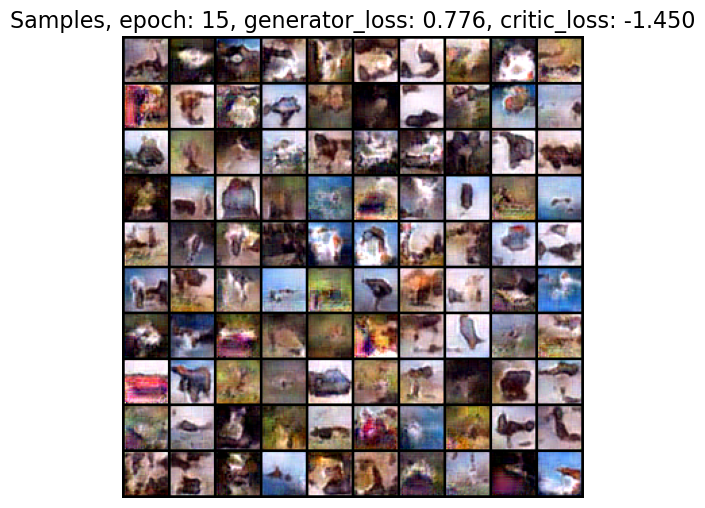

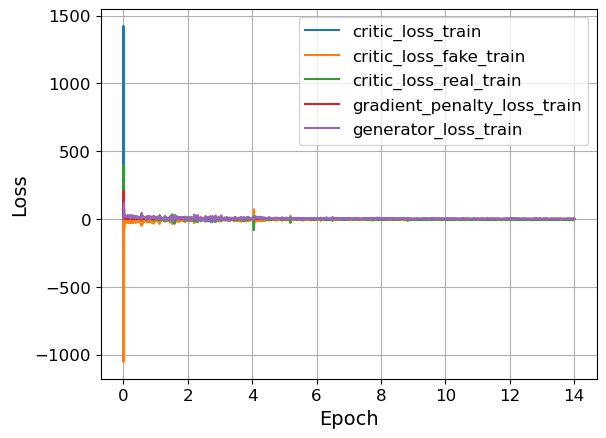

Training epoch 16:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
# ====
# your code
# choose these parameters
BATCH_SIZE = 64
N_CHANNELS = 64
EPOCHS = 100
CRITIC_STEPS = 5
GP_WEIGHT = 10.0
LR = 2e-4
# ====

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
wgan_gp = WGAN_GP(gp_weight=GP_WEIGHT, input_size=128, n_channels=N_CHANNELS)

# ====
# your code
# choose any optimizer as you want
generator_optimizer = torch.optim.RMSprop(wgan_gp.generator.parameters(), lr=LR)
discriminator_optimizer = torch.optim.RMSprop(wgan_gp.discriminator.parameters(), lr=LR)
# ====

train_adversarial(
    wgan_gp,
    train_loader,
    epochs=EPOCHS,
    d_steps=CRITIC_STEPS,
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    device=DEVICE,
    generator_loss_key="generator_loss",
    discriminator_loss_key="critic_loss",
    n_samples=100,
    visualize_samples=True
)

Let sample from our model and draw the samples.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


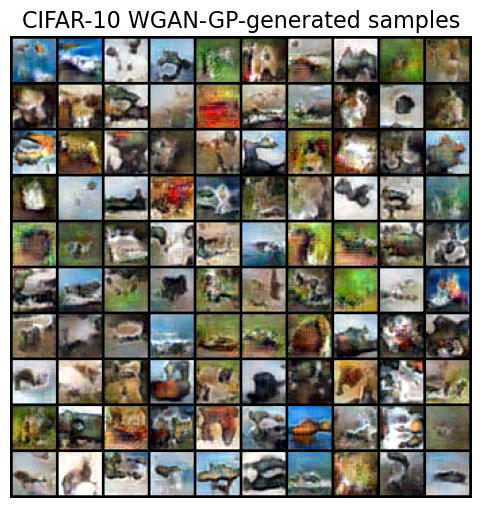

In [40]:
wgan_gp.eval()
samples = wgan_gp.sample(100).cpu().detach().numpy()

show_samples(samples, title="CIFAR-10 WGAN-GP-generated samples")

Here you have to get samples with good enough quality!